# Introduction

Studies have shown that regular running can lower [blood pressure](https://www.themanual.com/fitness/how-to-lower-blood-pressure/) and resting heart rate, improve blood sugar control, reduce triglycerides and [cholesterol](https://www.themanual.com/fitness/how-to-lower-cholesterol/) levels, as well as waist circumference and body fat percentage. Improving these health markers can reduce risk of disease and help to feel healthier overall.

As a software developer, I spend most of my time sitting in front of a computer at work or at university, this sedentary lifestyle has had a negative impact on my overall health, I was becoming less and less productive, got out of breath easily and had trouble with strenuous activity, Then I decided to take care of myself and start running regularly in **july 2021** and for about a year now the app I use ([Adidas Running](https://www.runtastic.com/)) has been collecting data from my workouts

This project aims to visualize and analyze my progress during this period to discover but also understand how certain factors have influenced my performance and also how I could improve or adapt my training to be able to run a **40km marathon**


# Objective

I would like to make my data speak, to do this I will start by asking myself some general questions in order to orientate my analysis and research, the general objective is to answer the following questions:

- What day of the week do I run the most?
- Does the temperature influence my performance?
- What is the best time to run?
- Has my average speed increased over time?
- How long did I run in total?
- How many kilometres did I run in total ?
- How many calories did I burn in total?

from this create a model that could help me predict my future performance based on all the data collected.

In [118]:
!pip install pandas numpy matplotlib seaborn calmap

# Data Cleaning & Shaping

The objective of data cleaning is to fix any data that is incorrect, inaccurate, incomplete, incorrectly formatted, duplicated, or even irrelevant to the objective of the data set. 

The data exported from Adidas running is separated in several files and each file includes a uuid and the date of the sport activity in the file name, the same information is included in the file in json format. 

To facilitate the processing I will keep only the uuid as file name to facilitate the liason with the other data (gps and elevation)


In [119]:
import fnmatch
import shutil
import re
import os
import json
import datetime as dt

def formatDatasetFilename(source: str, destination: str, extension: str = 'json') -> list :
    formatedFilenames = [];
    shutil.rmtree(destination, ignore_errors=True)
    os.mkdir(destination)

    for file in os.listdir(source):
        if fnmatch.fnmatch(file, f'*.{extension}'):

            # removing datetime from original filename
            filename = os.path.join(destination, re.sub("^(.*?)UTC_", "", file))
            shutil.copy(os.path.join(source, file), filename)
            formatedFilenames.append(filename)
    
    return formatedFilenames;

sessions = formatDatasetFilename('./dataset/Sport-sessions', './data/sessions');
gps = formatDatasetFilename('./dataset/Sport-sessions/GPS-data', './data/gps', extension='gpx');
elevations = formatDatasetFilename('./dataset/Sport-sessions/Elevation-data', './data/elevations')

# parse the content of jsons files
sessions_data = []
for session in sessions:
    with open(session, 'r') as f:
        sessions_data.append(json.load(f))

# removing non running sport session
sessions_data = list(filter(lambda session: session['sport_type_id'] == '1', sessions_data))

## Normalization/standardization of feature values

In [120]:
# converting unix timestamp to datatime object
def timestampToDatetime(session: dict, fields: list) -> None :
    for field in fields:
        timestamp = int(session[field]) / 1000
        timezone = dt.timezone(dt.timedelta(seconds=7200)) #UTC+2
        session[field] = dt.datetime.fromtimestamp(timestamp, tz=timezone)

# formalizing data
for session in sessions_data:
    session['distance'] = session['distance'] / 1000.0
    session['duration'] = round((session['duration'] / 1000) / 60, 2)
    session['max_speed'] = round(float(session['max_speed']), 2)
    session['average_speed'] = round(float(session['average_speed']), 2)
    session['elevation_loss'] = session['elevation_loss'] * -1
    session['elevation'] = session['elevation_gain'] + session['elevation_loss']
    timestampToDatetime(session,['start_time', 'end_time', 'created_at', 'updated_at'])

## Feature engineering: new derived features

In [121]:
import pandas as pd
import numpy as np
import datetime as dt
from datetime import datetime

sessions_df = pd.DataFrame(sessions_data)

# Creating new features from the data
sessions_df['year'] = sessions_df.start_time.dt.year
sessions_df['month'] = sessions_df.start_time.dt.month
sessions_df['weekday'] = sessions_df.start_time.dt.day_name()
sessions_df['created_at'] = sessions_df.start_time.dt.date
sessions_df['weekday_number'] = sessions_df.start_time.dt.weekday

# 2021 data only
sessions_df = sessions_df[sessions_df['created_at'] >= dt.date(2021, 1, 1)]

# Exploratory Data Plots

In [122]:
import matplotlib.pyplot as plt
colors = {
    "black": "#000",
    "white": "#fff",
    "gray": {50: "#f9fafb", 100: "#f3f4f6", 200: "#e5e7eb", 300: "#d1d5db", 400: "#9ca3af", 500: "#6b7280", 600: "#4b5563", 700: "#374151",800: "#1f2937",900: "#111827"},
    "red": {50: "#fef2f2",100: "#fee2e2",200: "#fecaca",300: "#fca5a5",400: "#f87171",500: "#ef4444",600: "#dc2626",700: "#b91c1c",800: "#991b1b",900: "#7f1d1d"},
    "orange": {50: "#fff7ed",100: "#ffedd5",200: "#fed7aa",300: "#fdba74",400: "#fb923c",500: "#f97316",600: "#ea580c",700: "#c2410c",800: "#9a3412",900: "#7c2d12"},
    "blue": {50: "#eff6ff",100: "#dbeafe",200: "#bfdbfe",300: "#93c5fd",400: "#60a5fa",500: "#3b82f6",600: "#2563eb",700: "#1d4ed8",800: "#1e40af",900: "#1e3a8a"},
}


### Sport Session Frequency 

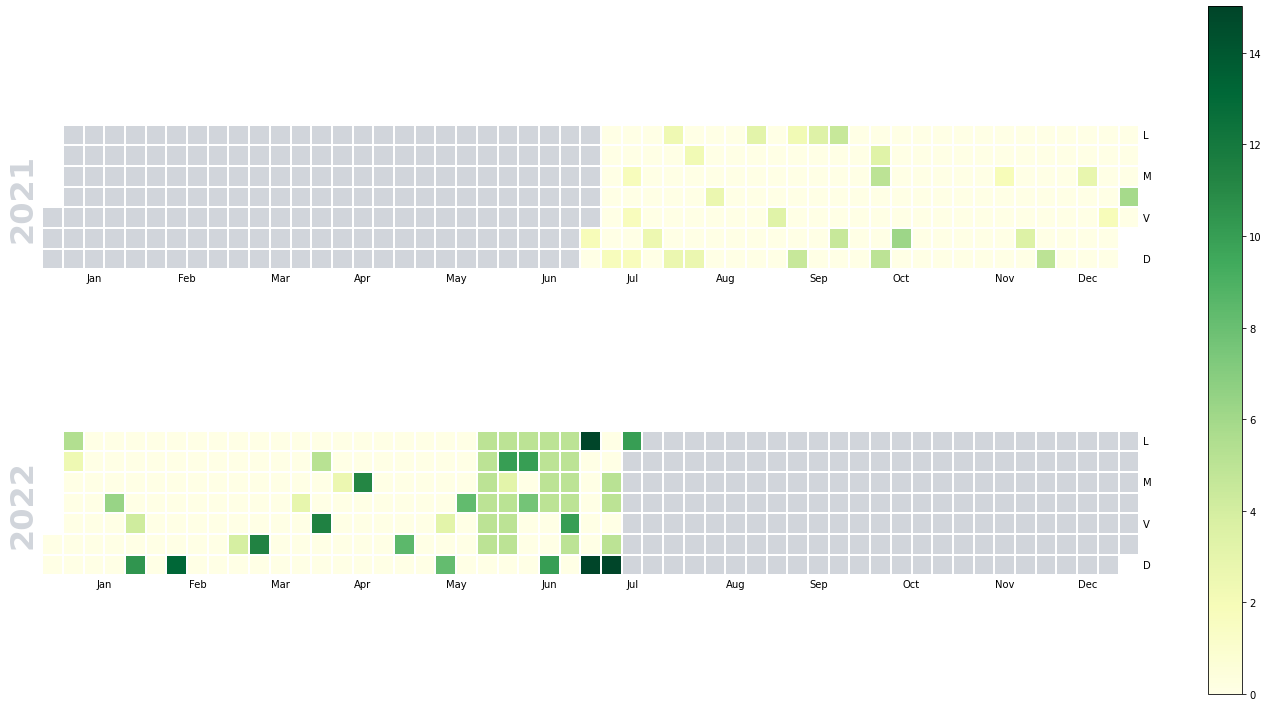

In [123]:
import calmap

sessions_calmap = sessions_df[['created_at', 'distance']].sort_values(by='created_at')
sessions_calmap = sessions_calmap.reset_index(drop=True)
sessions_calmap = pd.Series(
    sessions_calmap['distance'].tolist(),
    pd.DatetimeIndex(sessions_calmap['created_at'].tolist())
);

plt.rcParams["figure.figsize"] = (20, 10)
fig,ax = calmap.calendarplot(
    sessions_calmap,
    monthticks=3,
    cmap='YlGn', 
    fillcolor= colors['gray'][300],
    daylabels='LMMJVSD',
    linewidth=2,
    dayticks=[0, 2, 4, 6],
    fig_kws=dict(figsize=(20, 10))
);

fig.colorbar(ax[0].get_children()[1], ax=ax.ravel().tolist());

### Total distance per day

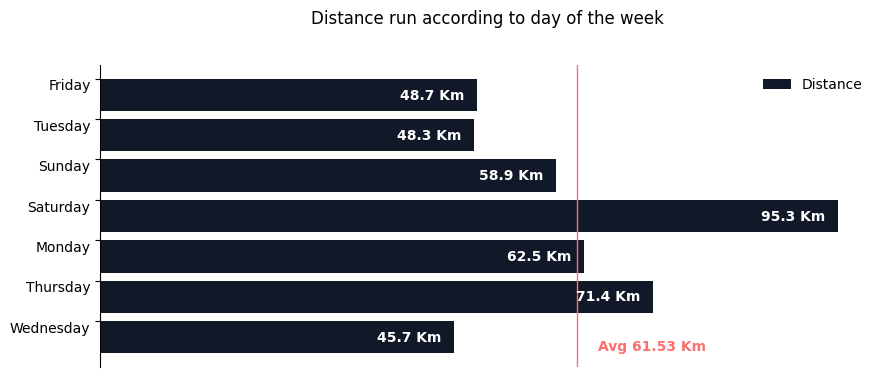

In [124]:
def repartitionPlot(x: list, y: list, title: str, label: str) -> None:
    fig, ax = plt.subplots(figsize=(10, 4), dpi=100)
    bar_width = 0.80
    ind = np.arange(len(y))
    
    average = np.average(y.tolist());
    
    ax.barh(ind, y, bar_width)
    ax.set_yticks(ind + bar_width / 2)
    ax.set_yticklabels(x, minor=False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.get_xaxis().set_ticks([])

    plt.title(title)
    plt.rcParams['axes.titlepad'] = 30
    ax.axvline(average, color=colors['red'][400], linewidth=1)
    ax.barh(x, y, color=colors['gray'][900], label=label)
    ax.legend(frameon=False)

    for label in ax.get_yticklabels():
        label.set_verticalalignment('top')

    for i, v in enumerate(y):
        ax.text(v - 10, i - .1, str(round(v, 1)) + " Km", color='white', fontweight='bold')
        
    
    for data, xoff in zip([y.tolist()], [15, -15]):
        x0 = average
        align = 'left' if xoff > 0 else 'right'

        ax.annotate(
            'Avg {:0.2f} Km'.format(x0), 
            xy=(x0, 0), 
            xytext=(xoff, 15),
            xycoords=('data', 'axes fraction'), 
            textcoords='offset points',
            fontweight='bold',
           horizontalalignment=align, 
            verticalalignment='center',
            color=colors['red'][400],
        )
        
    plt.show();

repartitionPlot(
    x=sessions_df['weekday'].unique(), 
    y=sessions_df.groupby(sessions_df['weekday'])[['distance']].sum()['distance'], 
    title="Distance run according to day of the week", 
    label="Distance"
)

### Distance progression over duration

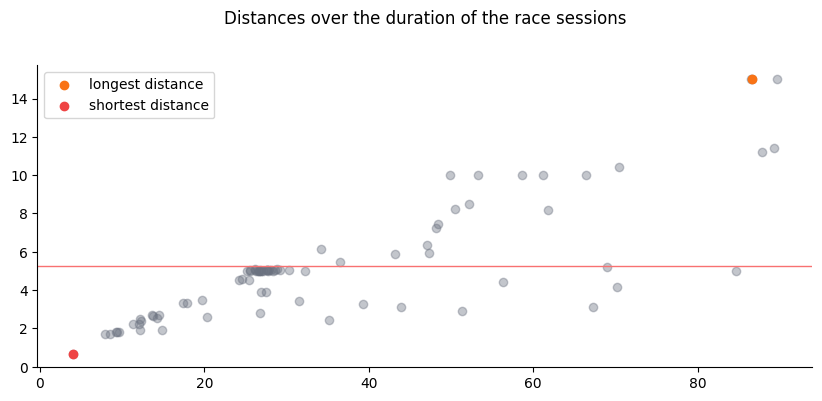

In [125]:
distances_df = sessions_df[['duration', 'distance']].sort_values(by="distance")

minimum = distances_df['distance'].min()
maximum = distances_df['distance'].max()
average = distances_df['distance'].mean()
  
fig, ax = plt.subplots(figsize=(10, 4), dpi=100)
plt.title("Distances over the duration of the race sessions")
plt.rcParams['axes.titlepad'] = 30
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.axhline(average, color=colors['red'][400], linewidth=1)
ax.scatter(distances_df['duration'], distances_df['distance'], color=colors['gray'][500], alpha=0.4)
ax.scatter(
    distances_df['duration'][distances_df['distance'] == maximum], 
    maximum, 
    color=colors['orange'][500],
    label="longest distance"
)
ax.scatter(
    distances_df['duration'][distances_df['distance'] == minimum], 
    minimum, 
    color=colors['red'][500],
    label="shortest distance"
)
ax.legend();

### Average speed progression over time

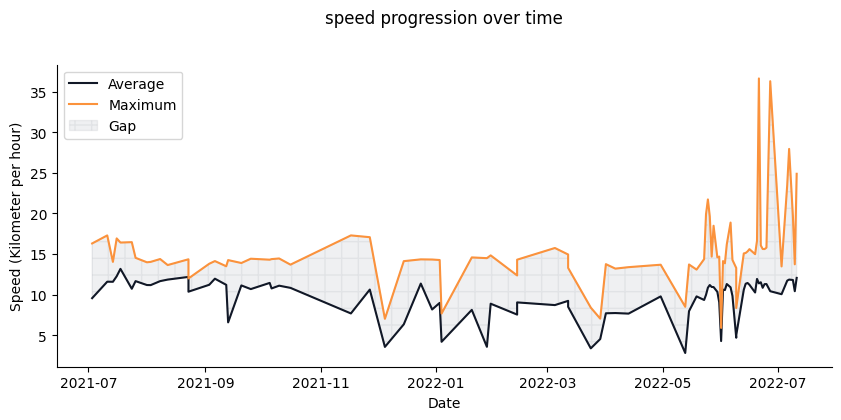

In [126]:
speed_df = sessions_df[['created_at', 'max_speed', 'average_speed']].sort_values(by='created_at')
speed_df = speed_df.reset_index(drop=True)
speed_df = speed_df[speed_df['created_at'] > dt.date(2021, 1, 1)]

fig, ax = plt.subplots(figsize=(10, 4), dpi=100)
plt.title("speed progression over time")
plt.rcParams['axes.titlepad'] = 30
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.xlabel("Date")
plt.ylabel("Speed (Kilometer per hour)")

ax.plot(
    speed_df['created_at'], 
    speed_df['average_speed'], 
    color=colors['gray'][900],
    label="Average"
)
ax.plot(
    speed_df['created_at'], 
    speed_df['max_speed'], 
    color=colors['orange'][400],
    label="Maximum",
    linestyle="-"
)
ax.fill_between(
    speed_df['created_at'], 
    speed_df['average_speed'],
    speed_df['max_speed'],
    color=colors['gray'][500], 
    alpha=0.1,
    hatch="+",
    label="Gap"
)

ax.legend();
plt.show();

### Number of steps according to the distance covered

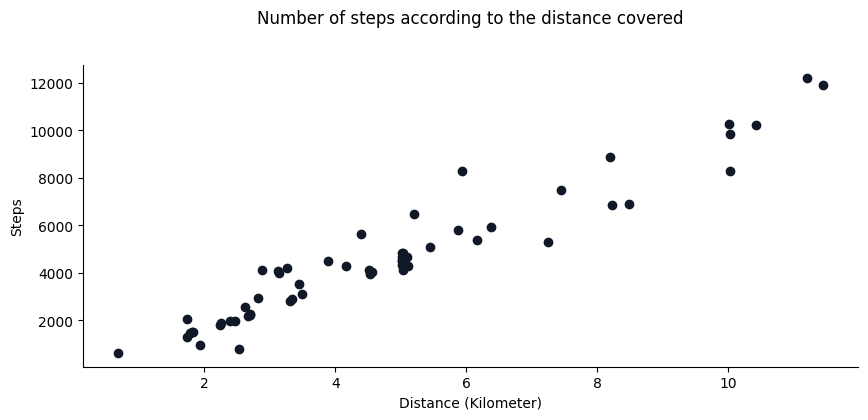

In [127]:
speed_df = sessions_df[['created_at', 'max_speed', 'total_steps', 'distance']].sort_values(by='created_at')
speed_df = speed_df.reset_index(drop=True)
speed_df = speed_df[speed_df['created_at'] > dt.date(2021, 1, 1)]

fig, ax = plt.subplots(figsize=(10, 4), dpi=100)
plt.title("Number of steps according to the distance covered")
plt.rcParams['axes.titlepad'] = 30
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.xlabel("Distance (Kilometer)")
plt.ylabel("Steps")

ax.scatter(
    speed_df['distance'], 
    speed_df['total_steps'], 
    color=colors['gray'][900],
);

### Temperatures during running sessions

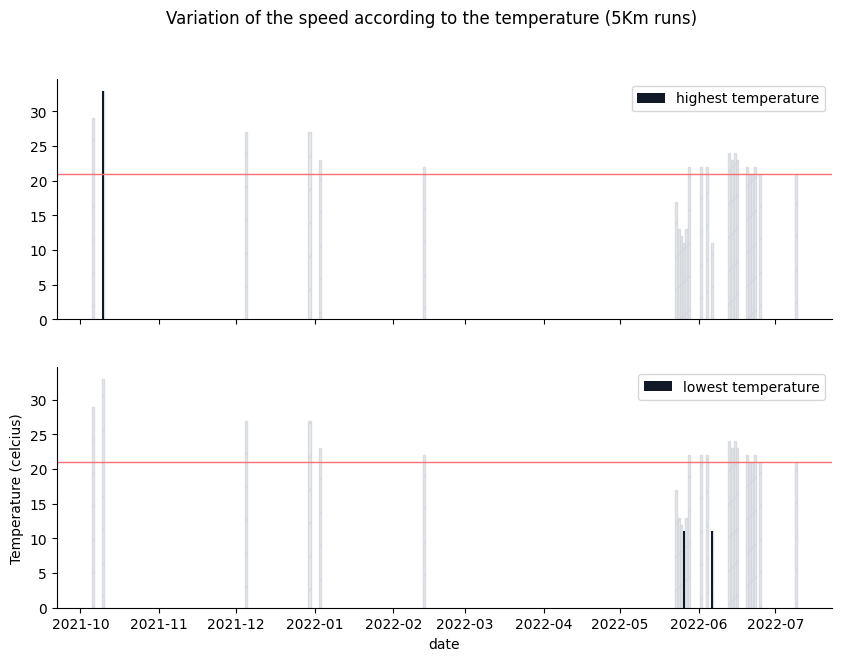

In [128]:
temperature_df = temperature_df[['distance', 'duration', 'temperature', 'created_at']].dropna()
temperature_df = temperature_df.loc[temperature_df['distance'] >= 5]
temperature_df = temperature_df.loc[temperature_df['distance'] < 6].reset_index(drop=True)

minimum = temperature_df['temperature'].min()
maximum = temperature_df['temperature'].max()
average = temperature_df['temperature'].mean()

fig, axs = plt.subplots(2, figsize=(10, 7), dpi=100, sharex=True, sharey=True)
fig.suptitle("Variation of the speed according to the temperature (5Km runs)")
plt.rcParams['axes.titlepad'] = 30
plt.xlabel("date")
plt.ylabel("Temperature (celcius)")

axs[0].bar(
    temperature_df['created_at'],
    temperature_df['temperature'],
    color=colors['gray'][200],
    hatch="/",
    edgecolor=colors['gray'][300],
    alpha=0.8
);
axs[0].bar(
    temperature_df['created_at'][temperature_df['temperature'] == maximum], 
    maximum, 
    color=colors['gray'][900],
    label="highest temperature",
)

axs[1].bar(
    temperature_df['created_at'],
    temperature_df['temperature'],
    color=colors['gray'][200],
    hatch="/",
    edgecolor=colors['gray'][300],
    alpha=0.8
);
axs[1].bar(
    temperature_df['created_at'][temperature_df['temperature'] == minimum], 
    minimum, 
    color=colors['gray'][900],
    label="lowest temperature",
);

for ax in axs:
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.axhline(average, color=colors['red'][400], linewidth=1)
    ax.legend();elevation_df = sessions_df[sessions_df['created_at'] > dt.date(2021, 1, 1)]

### Elevation gain and loss over time

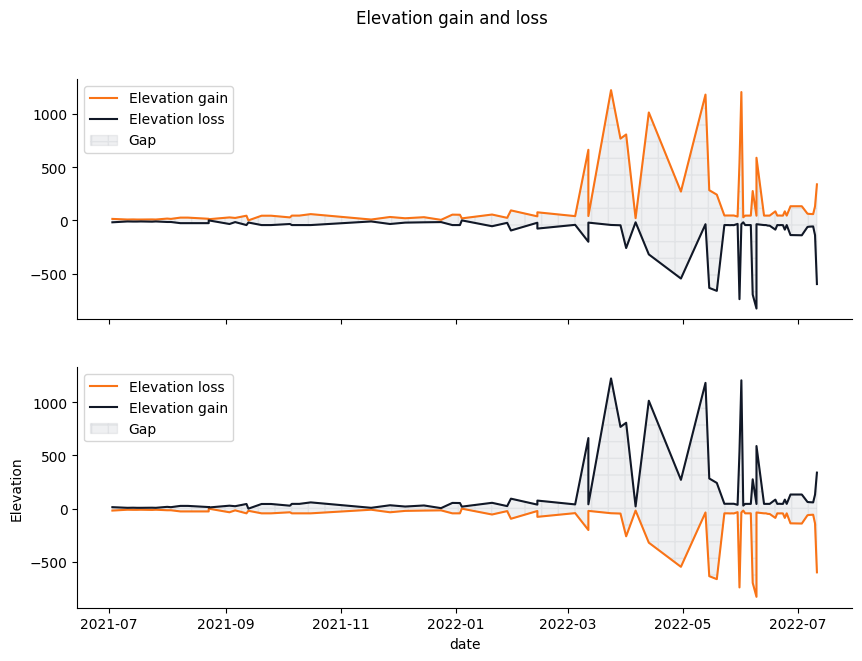

In [129]:
elevation_df = sessions_df[['created_at', 'elevation_gain', 'elevation_loss', 'distance']].sort_values(by='created_at')
elevation_df = elevation_df.reset_index(drop=True)
elevation_df = elevation_df[elevation_df['created_at'] > dt.date(2021, 1, 1)]

minimum = elevation_df['elevation_gain'].min()
maximum = elevation_df['elevation_gain'].max()
average = elevation_df['elevation_gain'].mean()

fig, axs = plt.subplots(2, figsize=(10, 7), dpi=100, sharex=True, sharey=True)
fig.suptitle("Elevation gain and loss")
plt.rcParams['axes.titlepad'] = 30
plt.xlabel("date")
plt.ylabel("Elevation")

axs[0].plot(
    elevation_df['created_at'],
    elevation_df['elevation_gain'],
    color=colors['orange'][500],
    label="Elevation gain"
);

axs[0].plot(
    elevation_df['created_at'],
    elevation_df['elevation_loss'],
    color=colors['gray'][900],
    label="Elevation loss"
);

axs[1].plot(
    elevation_df['created_at'],
    elevation_df['elevation_loss'],
    color=colors['orange'][500],
    label="Elevation loss"
);

axs[1].plot(
    elevation_df['created_at'],
    elevation_df['elevation_gain'],
    color=colors['gray'][900],
    label="Elevation gain"
);

for ax in axs:
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False);
    ax.fill_between(
        elevation_df['created_at'], 
        elevation_df['elevation_loss'],
        elevation_df['elevation_gain'],
        color=colors['gray'][500], 
        alpha=0.1,
        hatch="+",
        label="Gap"
    )
    ax.legend();

### Elevation gain and lost on 5km runs

In [ ]:
elevation_df = sessions_df[['created_at', 'elevation_gain', 'elevation_loss', 'distance', 'elevation']].sort_values(by='created_at')
elevation_df = elevation_df.loc[elevation_df['distance'] >= 5]
elevation_df = elevation_df.loc[elevation_df['distance'] < 6].reset_index(drop=True)

fig, axs = plt.subplots(2, figsize=(10, 7), dpi=100, sharex=True, sharey=True)
fig.suptitle("Elevation gain on 5km runs")
plt.rcParams['axes.titlepad'] = 30
plt.xlabel("date")
plt.ylabel("Elevation")

axs[0].scatter(
    elevation_df['distance'],
    elevation_df['elevation_gain'],
    color=colors['orange'][500],
    label="Elevation gain"
);

axs[0].scatter(
    elevation_df['distance'],
    elevation_df['elevation_loss'],
    color=colors['gray'][900],
    label="Elevation loss"
);

axs[1].scatter(
    elevation_df['distance'],
    elevation_df['elevation_gain'],
    color=colors['orange'][500],
    label="Elevation gain"
);

axs[1].scatter(
    elevation_df['distance'],
    elevation_df['elevation_loss'],
    color=colors['gray'][900],
    label="Elevation loss"
);

axs[1].plot(
    elevation_df['distance'],
    elevation_df['elevation'],
    color=colors['red'][300],
    label="Elevation",
    linestyle="--"
);

for ax in axs:
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False);
    ax.legend();